In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
import seaborn as sns
from enum import Enum
import matplotlib.colors as mcolors
import colorsys
import os

In [110]:
# results = pd.read_csv("../test_results/hyper_sdqlpy_dense_tuning_test_results.csv") 
results = pd.read_csv("../test_results/hyper_sdqlpy_pandas_tpch_direct_optimisations_test_results.csv") 

In [111]:
print(f"Overall Results: {len(results)}")

# Filter for Correct == True and Executed == Yes
results = results[(results.Correct == True) & (results.Executed == "Yes")]
print(f"Correct Results: {len(results)}")

Overall Results: 176
Correct Results: 176


In [112]:
def g_mean(x):
    a = np.log(x)
    return np.exp(a.mean())

def pre_process(df):
    # Sort Query Name column to in-order
    def extract_number(name):
        if isinstance(name, int):
            return name
        else:
            return int(name.split(" ")[1])

    df['Query Number'] = df.apply(lambda row : extract_number(row['Query Number']), axis = 1)
    df = df.sort_values(['Query Number'])

    # Fix the runs column
    def fix_runs(runs):
        new_runs = list(str(str(runs)[1:-1]).split(","))
        for i in range(0, len(new_runs)):
            new_runs[i] = float(new_runs[i].strip())
        return new_runs

    df['Runs'] = df.apply(lambda row : fix_runs(row['Runs']), axis = 1)

    def ignore_first_gmean(runs):
        return g_mean(runs[1:])
    
    def ignore_first_mean(runs):
        return sum(runs[1:]) / len(runs[1:])

    df["Mean"] = df.apply(lambda row : ignore_first_mean(row['Runs']), axis = 1)
    df["Query Type"] = df["Query Name"]
    df = df[["Query Type", "Query Number", "Mean", "Runs"]]
    
    return df

results = pre_process(results)

In [113]:
def make_overall_table(df):
    overall = df.groupby("Query Type").agg(
        overall_mean_runtime=("Mean", g_mean)
    )
    overall = overall.sort_values(by="overall_mean_runtime")
    overall = overall.rename(columns={"overall_mean_runtime": "Overall Mean Runtime (s)"})
    return overall

In [114]:
overall = make_overall_table(results)
# overall.head(15)

## Boxplots

In [115]:
results['Query Type'] = results['Query Type'].replace(
    {
        'Pandas Converted (Hyper DB)': 'Pandas',
        'Pandas Converted + O4 (Hyper DB)': 'O4 Pandas'
    }
)

In [116]:
# Compare 
compare_groups = [
    ("O1_graph.pdf", ["Naive SDQLpy", "O1 SDQLpy", "Pandas", "O4 Pandas"]),
    ("O2_graph.pdf", ["Naive SDQLpy", "O2 SDQLpy"]),
    ("O3_graph.pdf", ["Naive SDQLpy", "O3 SDQLpy"]),
    ("O4_graph.pdf", ["Naive SDQLpy", "O4 SDQLpy"])
]

In [117]:
def make_boxplot_graph(original_df, data_labels, filename = None):
    new_df = original_df[original_df["Query Type"].isin(data_labels)]
    # Convert to ms
    new_df['Mean'] = new_df['Mean'].apply(lambda x : x * 1000)

    sns.set_theme(rc={'figure.figsize':(8,6)})

    ax = sns.boxplot(data=new_df, x="Query Type", y="Mean", color="#D9D9D9", linecolor="#137", linewidth=.75)
    ax.set_ylabel("Runtime (ms)")
    ax.set_xlabel("")

    plt.tight_layout()
    plt.show()
    
    if filename != None:
        os.makedirs(os.path.dirname(filename), exist_ok=True)  
        plt.savefig(filename, bbox_inches="tight", transparent=True)

/tmp/ipykernel_736196/3511808713.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Mean'] = new_df['Mean'].apply(lambda x : x * 1000)


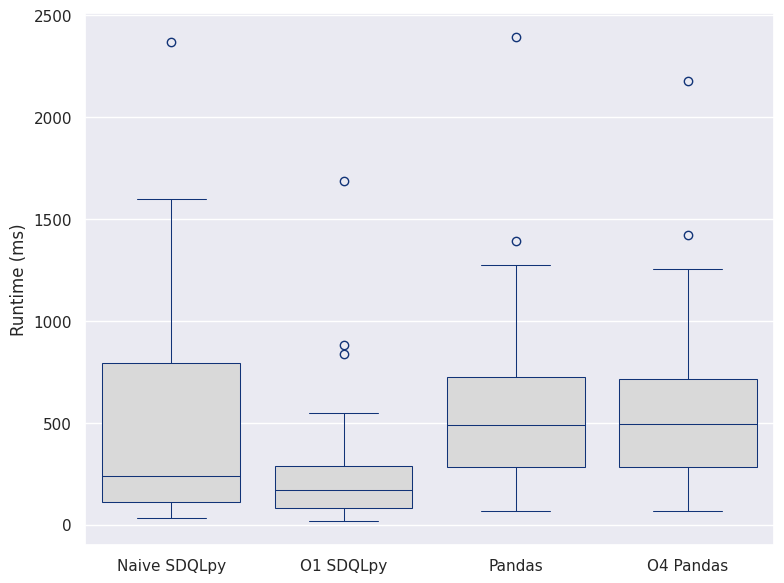

/tmp/ipykernel_736196/3511808713.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Mean'] = new_df['Mean'].apply(lambda x : x * 1000)


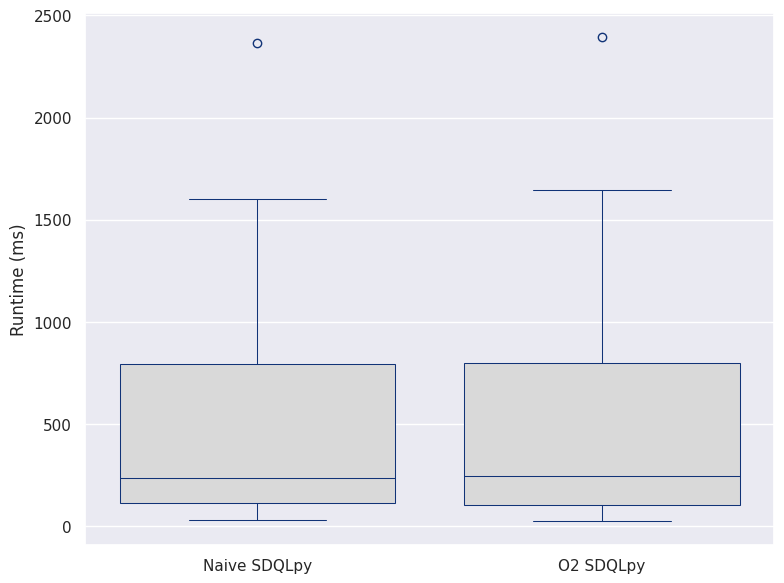

/tmp/ipykernel_736196/3511808713.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Mean'] = new_df['Mean'].apply(lambda x : x * 1000)


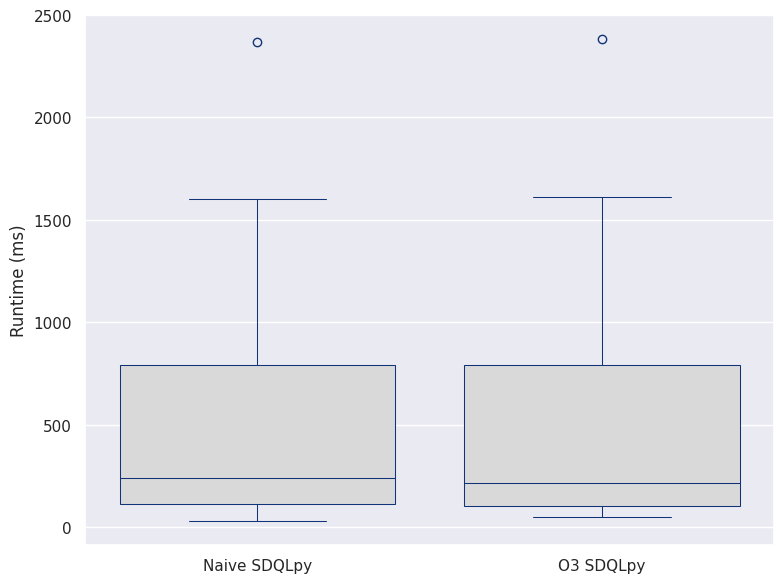

/tmp/ipykernel_736196/3511808713.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Mean'] = new_df['Mean'].apply(lambda x : x * 1000)


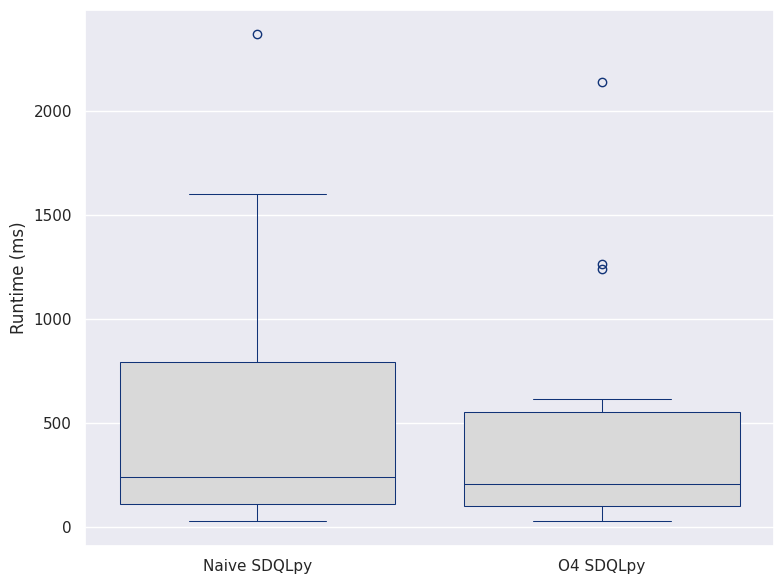

<Figure size 800x600 with 0 Axes>

In [118]:
for filename, data_labels in compare_groups:
    make_boxplot_graph(
        results,
        data_labels,
        f"../analysis_results/y2_report/{filename}"
    )